## Set Up
Please specify the following variables

In [0]:
#####################################################
#         Path Locations
#####################################################

FOLDER_PATH_FOR_DATA = "/content/drive/My Drive/JHU/2020 Spring Semester/Machine Learning: Deep Learning/Final Project RNN with CNN"
RESULTS_DIR = "/content/version3_results"


#####################################################
#         Hyperparameters
#####################################################

LR = 0.01
L2 = 0.00001
EARLY_STOP_PATIENCE = 15
LR_PATIENCE = 10
MULTIPLICATIVE_FACTOR = 0.2
MAX_EPOCHES = 200
EPOCH_TO_SAVE = 5
MOMENTUM = 0.9

In [0]:
#####################################################
#         Imports
#####################################################

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import time
import copy
import os
import pandas as pd
from skimage import io, transform
from torchvision import utils
from torch.utils.tensorboard import SummaryWriter
from PIL import Image

from shutil import move, copyfile
import shutil
import zipfile
import xlrd 
import csv
from random import randrange
import matplotlib.pyplot as plt

In [0]:
#####################################################
#         Setting up the Environment
#####################################################

# Mounting drive to get raw data
from google.colab import drive
drive.mount('/content/drive')

# Obtaining and organizing raw data

ROOT = os.getcwd()

raw_data_path = os.path.join(FOLDER_PATH_FOR_DATA, "raw image.zip")
with zipfile.ZipFile(raw_data_path, 'r') as zip_ref:
    zip_ref.extractall(ROOT)

for filename in os.listdir(os.path.join(ROOT, 'raw image')):
    move(os.path.join(ROOT, 'raw image', filename), os.path.join(ROOT, filename))

# Obtaining and organizing labels
train_label_src = os.path.join(FOLDER_PATH_FOR_DATA, "train_labels.csv")
train_label_des = os.path.join(ROOT, "train_labels.csv")
copyfile(train_label_src, train_label_des)

val_label_src = os.path.join(FOLDER_PATH_FOR_DATA, "validation_labels.csv")
val_label_des = os.path.join(ROOT, "validation_labels.csv")
copyfile(val_label_src, val_label_des)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


'/content/validation_labels.csv'

In [0]:
#####################################################
#         Parsing Labels
#####################################################

def gen_map_of_labels(file_path):
    workbook = xlrd.open_workbook(file_path) 
    sheet = workbook.sheet_by_index(0)

    unique_cell_numbers = set([])
    new_labels = {}

    video_name = sheet.cell_value(1, 0)
    new_labels['video'] = video_name

    frame_i = 1
    cell_number_i = 3
    num_frames = 0
    for i in range(1, sheet.nrows):
        frame = str(int(sheet.cell_value(i, frame_i)))
        cell_number = sheet.cell_value(i, cell_number_i)

        unique_cell_numbers.add(cell_number)

        # Dynamic cell count
        new_labels['d' + frame] = len(unique_cell_numbers)

        # Static cell count
        if 's' + frame in new_labels:
            new_labels['s' + frame] = new_labels['s' + frame] + 1
        else:
            new_labels['s' + frame] = 1

        num_frames = num_frames + 1

    # -1 for the "video" key
    new_labels['number of frames'] = (len(new_labels.keys())-1)//2 
    return new_labels

def write_map_of_labels(path_to_save, map_of_labels):
    with open(path_to_save, 'w') as csv_file:  
        writer = csv.writer(csv_file)

        writer.writerow([map_of_labels["video"]])
        writer.writerow(["Frame", "Dynamic Count", "Static Count"])
        
        num_frames = map_of_labels["number of frames"]
        for i in range(1, num_frames + 1):
            writer.writerow([i, map_of_labels['d%d'%i], map_of_labels['s%d'%i]])

def gen_and_save_new_labels():
    new_labels = gen_map_of_labels("/content/Data/train/cellLabel.xlsx")
    print(new_labels)
    write_map_of_labels("/content/train_labels.csv", new_labels)

    new_labels = gen_map_of_labels("/content/Data/val/cellLabel.xlsx")
    print(new_labels)
    write_map_of_labels("/content/validation_labels.csv", new_labels)

# ! git clone https://github.com/Shu244/Cytometry-for-Google-Colab.git
# !unzip /content/Cytometry-for-Google-Colab/Data.zip
# gen_and_save_new_labels()

In [0]:
#####################################################
#         Defining Dataset
#####################################################

class OneVideo:
    def __init__(self, input_path, label_path, transform):
        self.frameI = 0
        self.frames = self.grayscale_to_RGB(input_path)
        self.labels = self.process_label_file(label_path)
        self.transform = transform

    def process_label_file(self, label_path):
        with open(label_path, "r") as file:
            reader = csv.reader(file)
            next(reader) # Skip information about video
            next(reader) # Skip headers
            return [(int(line[1]), int(line[2])) for line in reader];
    
    def grayscale_to_RGB(self, input_path):
        grayscale_frames = io.imread(input_path)
        rgb_frames = np.repeat(grayscale_frames[..., np.newaxis], 3, -1)
        return rgb_frames

    def num_frames(self):
        return self.frames.shape[0]

    def empty(self):
        return self.frameI == self.num_frames()

    def nextOne(self):
        frame = self.frames[self.frameI]
        label = self.labels[self.frameI]
        self.frameI = self.frameI + 1
                
        image = Image.fromarray(frame, 'RGB')
        image = self.transform(image)

        return image, label

    def next(self, amount=-1, testing=False):
        '''
            Each next() creates a new batch of inputs and labels
        '''
        if(amount < 1):
            amount = round(randrange(4, 14))

        current_label = self.labels[self.frameI]
        # Dynamic Count - Static Count
        offset = current_label[0] - current_label[1]

        frame_batch = []
        label_batch = []
        used = 0
        while(not self.empty() and used < amount):
            frame, label = self.nextOne()
            frame_batch.append(frame)
            label_batch.append(label[0] - offset)
            used = used + 1

        if testing:
            return torch.stack(frame_batch), torch.tensor(label_batch), offset
        else:
            return torch.stack(frame_batch), torch.tensor(label_batch)

class CellDataset():
    def __init__(self, input_paths, label_paths, transform=None):
        """
        Args:
            input_paths (list of strings): list of paths for the tiff video inputs
            label_paths (list of strings): list of paths for the csv labels
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.input_paths = input_paths
        self.label_paths = label_paths
        if transform:
            self.transform = transform
        else:
            self.transform = transforms.ToTensor()

    def len(self):
        return len(self.label_paths)

    def get_video(self, idx):
        return OneVideo(self.input_paths[idx], self.label_paths[idx], self.transform)

    def next(self):
        random_index = randrange(self.len())
        return self.get_video(random_index)

def test_dataset():
    train_data_paths = ["/content/GFC_505nm_40X1p15NA_PCO_500usexp_160fps_3.tif"]
    train_label_paths = ["/content/train_labels.csv"]
    train_dataset = CellDataset(train_data_paths, train_label_paths)
    video = train_dataset.next()
    frames1, labels1 = video.next()
    frames2, labels2 = video.next();

    print('Frames 1 Shape: ', frames1.shape)
    print('Labels 1: ', labels1)
    print('Frames 2 Shape: ', frames2.shape)
    print('Labels 2: ', labels2)

# Image size (1280 width, 812 height) 
test_dataset()

Frames 1 Shape:  torch.Size([12, 3, 812, 1280])
Labels 1:  tensor([ 7, 10, 10, 10, 11, 11, 11, 14, 14, 15, 15, 15])
Frames 2 Shape:  torch.Size([11, 3, 812, 1280])
Labels 2:  tensor([ 7,  7,  8, 10, 10, 10, 10, 12, 12, 13, 14])


In [0]:
#####################################################
#         Creating Datasets with Augmentations
#####################################################

transform_train = transforms.Compose([
        transforms.RandomApply(
                [
                    transforms.ColorJitter(brightness=0.5, contrast=0.5)
                 ], 
                p=0.5
            ),
        transforms.CenterCrop((406, 640)),
        transforms.RandomCrop((400, 620)),
        transforms.RandomRotation(5),
        transforms.ToTensor()
    ])

transform_dev = transforms.Compose([
        transforms.CenterCrop((400, 620)),
        transforms.ToTensor()
    ])

# Creating the datasets
train_data_paths = ["/content/GFC_505nm_40X1p15NA_PCO_500usexp_160fps_3.tif"]
train_label_paths = ["/content/train_labels.csv"]
train_dataset = CellDataset(train_data_paths, train_label_paths, transform_train)

val_data_paths = ["/content/GFC_505nm_40X1p15NA_PCO_500usexp_160fps_3@0001.tif"]
val_label_paths = ["/content/validation_labels.csv"]
val_dataset = CellDataset(val_data_paths, val_label_paths, transform_dev)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if not os.path.exists(RESULTS_DIR):
    os.mkdir(RESULTS_DIR)

In [0]:
#####################################################
#         Early Stoping and Adaptive Learning Rate
#####################################################

# Credit: https://gist.github.com/stefanonardo/693d96ceb2f531fa05db530f3e21517d
class HistoryTracker(object):
    def __init__(self, mode='min', min_delta=0, patience=10, percentage=False):
        '''
        Args:
            mode: min or max
            min_delta: new metric has to be within min_delta to be consider better than current best_metric
            patience: patience before stopping.
            percentage: if min_delta is a percentage, then true; false otherwise.
        '''
        self.mode = mode
        self.min_delta = min_delta
        self.patience = patience
        self.best = None # No best yet.
        self.num_bad_epochs = 0 # No bad epoches yet
        self.is_better = None
        self._init_is_better(mode, min_delta, percentage)

        # Never stop if patience is 0 and always save the new metric.
        if patience == 0:
            self.is_better = lambda a, b: True
            self.out_of_patience = lambda a: False

    # metric represents the values you are measuring for early stopping. 
    # returns true to stop 
    def out_of_patience(self, metrics):
        # When starting, best is set to be the first metric
        if self.best is None:
            self.best = metrics
            return False

        if self.is_better(metrics, self.best):
            self.num_bad_epochs = 0
            self.best = metrics
        else:
            self.num_bad_epochs += 1

        if self.num_bad_epochs >= self.patience:
            return True

        return False

    # Custom method to determine what is better.
    def _init_is_better(self, mode, min_delta, percentage):
        if mode not in {'min', 'max'}:
            raise ValueError('mode ' + mode + ' is unknown!')
        if not percentage:
            if mode == 'min':
                self.is_better = lambda a, best: a < best - min_delta
            if mode == 'max':
                self.is_better = lambda a, best: a > best + min_delta
        else:
            if mode == 'min':
                self.is_better = lambda a, best: a < best - (
                            best * min_delta / 100)
            if mode == 'max':
                self.is_better = lambda a, best: a > best + (
                            best * min_delta / 100)

In [0]:
#####################################################
#         VGG16_bn Feature Extractor
#####################################################

class Feature_Extractor:
    def __init__(self):
        model = models.vgg16_bn(pretrained=True) 
        feature_extractor_cpu = nn.Sequential (
            *(list(model.features.children())[:-1]), 
            nn.MaxPool2d(kernel_size=6, stride=3, padding=0, dilation=1, ceil_mode=False)
            )
        self.feature_extractor = feature_extractor_cpu.to(device)
        self.feature_extractor.eval()
    
    def extract(self, frames):
        features = self.feature_extractor(frames)
        return torch.flatten(features, start_dim=1)
    
feature_extractor = Feature_Extractor()

Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /root/.cache/torch/checkpoints/vgg16_bn-6c64b313.pth


In [0]:
#####################################################
#        Custom RNN Model
#####################################################

class RNN(nn.Module):
    def __init__(self, input_size, num_layers):
        super(RNN, self).__init__()

        self.size1 = 512
        self.num_layers = num_layers
        self.LSTM = nn.LSTM(input_size, self.size1, self.num_layers)
        
        self.size2 = 350
        self.fc1 = nn.Linear(self.size1, self.size2, bias=True)
        self.relu = nn.ReLU()

        self.size3 = 1
        self.fc2 = nn.Linear(self.size2, self.size3, bias=True)

    def forward(self, input, hidden):
        output, hidden = self.LSTM(input, hidden)
        output = output.view(-1, self.size1)

        fc1_out = self.fc1(output)
        relu_out = self.relu(fc1_out)
        fc2_out = self.fc2(relu_out)

        return fc2_out, hidden
    
    def initHidden(self):
        return (torch.zeros(self.num_layers, 1, self.size1).to(device), 
                torch.zeros(self.num_layers, 1, self.size1).to(device))

rnn = RNN(39424, 2).to(device)

In [0]:
#####################################################
#        Get Feature Size
#####################################################

def test_feature_extraction():
    video = train_dataset.next()
    frames, labels = video.next(4)
    frames = frames.to(device)
    outputs = feature_extractor.extract(frames)
    print('Frames shape', frames.shape)
    print('Outputs shape', outputs.shape)
    print('Labels shape', labels.shape)

# test_feature_extraction()

In [0]:
#####################################################
#        Load and Save Models
#####################################################

def save_model(model, filename="parameters.pt"):
    path = os.path.join(RESULTS_DIR, filename)
    torch.save(model.state_dict(), path)
def load_parameters(model=None, filename="parameters.pt"):  
    print('Loading existing parameters.') 
    path = os.path.join(RESULTS_DIR, filename) 
    if model:
        # Device defaults of GPU
        model.load_state_dict(torch.load(path, map_location=device))
    else:
        model = create_model()
        model.to(device)
        # Device defaults of GPU
        model.load_state_dict(torch.load(path, map_location=device))
    return model;

In [0]:
#####################################################
#        Optimization Configurations
#####################################################

criterion = nn.L1Loss()
# optimizer = optim.SGD(rnn.parameters(), lr=LR, momentum=MOMENTUM, weight_decay=L2)
optimizer = optim.Adam(rnn.parameters(), lr=LR, weight_decay=L2)

In [0]:
#####################################################
#        Model Helper Functions
#####################################################

def get_predictions(frames):
    hidden = rnn.initHidden()

    num_frames = frames.shape[0]

    features = feature_extractor.extract(frames)
    (num_frames, num_features) = features.shape
    features = features.view(num_frames, 1, num_features)

    preds, hidden = rnn(features, hidden)
    preds = torch.flatten(preds)

    return preds, hidden

def get_logistics(preds, labels, criterion):
    losses = criterion(preds, labels)
    avg_loss = torch.mean(losses)
    
    return avg_loss, losses

def percent_err(preds, labels):
    labels = labels + 0.00000001
    return np.divide(np.abs(np.subtract(preds, labels)), labels)

def numpify(tensor):
    return tensor.cpu().detach().numpy()

In [0]:
#####################################################
#        One Training Loops
#####################################################

def train_one_video(video, criterion, optimizer):
    rnn.train()
    percent_err_arr = np.array([])
    loss = np.array([])
    while not video.empty():
        optimizer.zero_grad()

        frames, labels = video.next()
        frames = frames.to(device)
        labels = labels.to(device)

        preds, _ = get_predictions(frames)
        avg_loss, loss_batch = get_logistics(preds, labels, criterion)

        avg_loss.backward()
        optimizer.step()

        percent_err_arr = np.append(percent_err_arr, 
                                    percent_err(
                                        numpify(preds), 
                                        numpify(labels)
                                        )
                                    )
        loss = np.append(loss, numpify(loss_batch))
  
    return np.mean(percent_err_arr), np.mean(loss)

def validate_one_video(video, criterion):
    rnn.eval()
    percent_err_arr = np.array([])
    loss = np.array([])
    frame_i = 0
    with torch.no_grad():
        while not video.empty():
            frames, labels = video.next()
            num_frames = frames.shape[0]
            frames = frames.to(device)
            labels = labels.to(device)

            preds, _ = get_predictions(frames)
            avg_loss, loss_batch = get_logistics(preds, labels, criterion)

            human_preds = numpify(preds)
            human_labels = numpify(labels)
            percent_err_arr = np.append(percent_err_arr, 
                                        percent_err(
                                            human_preds, 
                                            human_labels
                                            )
                                        )
            loss = np.append(loss, numpify(loss_batch))

            print('')
            print('Frames %d-%d' % (frame_i, frame_i + num_frames))
            print(human_preds)
            print(human_labels)
            print('')

            frame_i = frame_i + num_frames
    
    return np.mean(percent_err_arr), np.mean(loss)


def test_train_one_video():
    video = train_dataset.next()
    avg_percent_err, avg_loss = train_one_video(video, criterion, optimizer)
    print('Percent Error', avg_percent_err)
    print('Average Loss', avg_loss)

def test_validate_one_video():
    video = val_dataset.next()
    avg_percent_err, avg_loss = validate_one_video(video, criterion)
    print('Percent Error', avg_percent_err)
    print('Average Loss', avg_loss)

# test_train_one_video()
# test_validate_one_video()

In [0]:
#####################################################
#        Training
#####################################################

best_model_parameters = {} # Uses global scope
def train_model(model, criterion, optimizer, early_stopping = None, lr_scheduler=None, tensorboardWriter=None, num_epochs=25, epoch_to_save=5):
    '''
    Args:
        model: model to train
        criterion: calculates loss
        optimizer: optimizer that takes step in gradient descent
        scheduler: schedule to adjust learning rate
        num_epoches:  epoches to train for
    '''

    # Used to track the time it takes to train a model.
    since = time.time()

    # Store the best parameters while training. 
    best_model_parameters = copy.deepcopy(model.state_dict())
    lowest_percent_err = 100

    record_i = 0

    for epoch in range(num_epochs):
        if epoch != 0 and epoch % epoch_to_save == 0:
            save_model(model)

        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # ----------------------------------Training Phase of Epoch-----------------------------------------------
        video = train_dataset.next()
        avg_percent_err, avg_loss = train_one_video(video, criterion, optimizer)
        if(tensorboardWriter):
            tensorboardWriter.add_scalar('Training Percent Error', avg_percent_err, record_i)
            tensorboardWriter.add_scalar('Training Avg Loss', avg_loss, record_i)

        # ----------------------------------Evaluating Phase of Epoch-----------------------------------------------        
        video = val_dataset.next()
        avg_percent_err, avg_loss = validate_one_video(video, criterion)
        print('Average Percent Error: ', avg_percent_err*100)
        print('Average Loss: ', avg_loss)
        if(tensorboardWriter):
            tensorboardWriter.add_scalar('Validation Percent Error', avg_percent_err*100, record_i)
            tensorboardWriter.add_scalar('Validation Avg Loss', avg_loss, record_i)

        record_i = record_i + 1

        # Deep copy the best model
        if lowest_percent_err > avg_percent_err:
            lowest_percent_err = avg_percent_err
            best_model_parameters = copy.deepcopy(model.state_dict())

        if(early_stopping and early_stopping.out_of_patience(avg_percent_err)):
            print('-' * 10)
            print('Early stopping used.')
            break

        if(lr_scheduler and lr_scheduler.out_of_patience(avg_percent_err)):
            lr_scheduler = HistoryTracker(mode='min', min_delta=0, patience=LR_PATIENCE, percentage=False)
            new_lr = 0
            for g in optimizer.param_groups:
                g['lr'] = g['lr'] * MULTIPLICATIVE_FACTOR
                new_lr = g['lr']
            print('-' * 10)
            print('Decreasing learning rate at epoch %d to %.8f' % (epoch, new_lr))

        # ---------------------------------- End Evaluating Phase of Epoch-----------------------------------------------
    
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Lowest Perent Error: {:4f}'.format(lowest_percent_err))

    model.load_state_dict(best_model_parameters)
    save_model(model)

In [0]:
#####################################################
#        Main
#####################################################

try: 
    path_of_params = os.path.join(RESULTS_DIR, "parameters.pt")
    if os.path.exists(path_of_params):
        rnn = load_parameters(rnn)

    early_stopping = HistoryTracker(mode='min', min_delta=0, patience=EARLY_STOP_PATIENCE, percentage=False)
    LR_scheduler = HistoryTracker(mode='min', min_delta=0, patience=LR_PATIENCE, percentage=False)
    path_to_save_tensorboard = os.path.join(RESULTS_DIR, 'runs')
    writer = SummaryWriter(path_to_save_tensorboard)
    train_model(rnn, criterion, optimizer, early_stopping, LR_scheduler, writer, MAX_EPOCHES, EPOCH_TO_SAVE)
except:
    print('Exception occurred and will now save best model.')
    rnn.load_state_dict(best_model_parameters)
    save_model(rnn)
finally:
    writer.close()

Epoch 0/199
----------

Frames 0-8
[ 6.0170865 11.021075  12.923837  13.228433  13.26477   13.2692585
 13.269607  13.269537 ]
[5 6 6 7 7 8 8 8]


Frames 8-21
[ 6.0158353 11.020286  12.92348   13.228718  13.265053  13.269333
 13.269618  13.269322  13.269322  13.269331  13.269523  13.269187
 13.268926 ]
[ 3  3  4  4  6  7  8  8  8 11 11 12 12]


Frames 21-26
[ 6.018471 11.0234   12.924502 13.228945 13.265122]
[5 6 6 7 7]


Frames 26-30
[ 6.011568  11.016389  12.922804  13.2282915]
[3 3 5 5]


Frames 30-43
[ 6.0160737 11.02097   12.924367  13.228567  13.264954  13.269175
 13.269416  13.269576  13.2692795 13.269288  13.269111  13.26907
 13.268895 ]
[ 4  4  5  5  5  6  6  7  7  7  8  8 10]


Frames 43-53
[ 6.0146937 11.019295  12.923404  13.228687  13.265108  13.269161
 13.269568  13.26965   13.26949   13.269311 ]
[4 4 4 7 7 7 7 9 9 9]


Frames 53-66
[ 6.0148478 11.019064  12.923592  13.228535  13.265109  13.269366
 13.269596  13.2695465 13.269511  13.269372  13.269049  13.268868
 13.26886 

RuntimeError: ignored

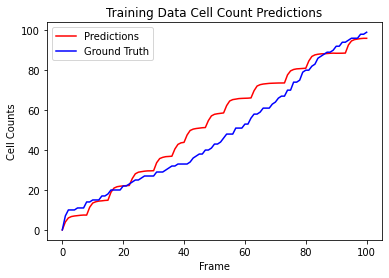

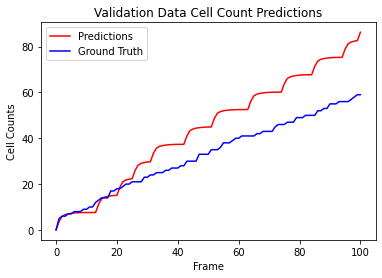

Training Prediction at 100 Frames: 96 Cells
Validation Prediction at 100 Frames: 86 Cells
Training Prediction at 50 Frames: 58 Cells
Validation Prediction at 50 Frames: 45 Cells


In [0]:
#####################################################
#        Testing
#####################################################

def test(video):
    rnn.eval()
    counts = np.array([0])
    ground_truth = np.array([0])
    with torch.no_grad():
        while not video.empty():
            frames, labels, offset = video.next(testing=True)
            frames = frames.to(device)
            preds, _ = get_predictions(frames)

            human_preds = numpify(preds)
            human_labels = numpify(labels)
            counts = np.append(counts, human_preds + counts[-1])
            ground_truth = np.append(ground_truth, human_labels + offset)
    return counts, ground_truth

def plot_vals(x, y, title, ylabel="Cell Counts", xlabel="Frame"):
    plt.plot(x, y[0], color="red", label="Predictions")
    plt.plot(x, y[1], color="blue", label="Ground Truth")
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    plt.title(title)
    plt.legend()
    plt.show()

def load_trained_model(path):
    rnn.load_state_dict(torch.load(path, map_location=device))

def run_test(load_from_else_where=False):
    if(load_from_else_where):
        print("Loading parameters from else where.")
        load_trained_model("/content/drive/My Drive/JHU/2020 Spring Semester/Machine Learning: Deep Learning/Final Project RNN with CNN/parameters.pt")

    train_results = test(train_dataset.next())
    val_results = test(val_dataset.next())

    x = np.arange(0, 101, 1)
    plot_vals(x, train_results, "Training Data Cell Count Predictions")
    plot_vals(x, val_results, "Validation Data Cell Count Predictions")

    print("Training Prediction at 100 Frames: %d Cells" % round(train_results[0][-1]))
    print("Validation Prediction at 100 Frames: %d Cells" % round(val_results[0][-1]))
    print("Training Prediction at 50 Frames: %d Cells" % round(train_results[0][50]))
    print("Validation Prediction at 50 Frames: %d Cells" % round(val_results[0][50]))
    # print("Training Predictions:", train_results)
    #print("Validation Predictions:", val_results)

# run_test(True)
run_test()

In [0]:
# Run only once to load tensorboard!
%load_ext tensorboard

In [0]:
# display tensorboard
%tensorboard --logdir='/content/version3_results/runs'